<a href="https://colab.research.google.com/github/statyanka/Product-analytics/blob/main/AB_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Введение

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Читаем данные и выводим их часть на экран:

In [ ]:
df_byuser = pd.read_csv('/content/hw_abt_2_byuser.csv', sep='\t')
df_byuser.head()

,Unnamed: 0,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,0,8,6630.000,0,0,0,8,A
1,1,13,6933.976,0,0,1,6,B
2,2,10,8261.976,1,10,1,8,B
3,3,4,5522.000,1,9,1,7,A
4,4,16,5075.976,1,6,0,8,B


In [ ]:
df_bybucket = pd.read_csv('/content/hw_abt_2_bybucket.csv', sep='\t')
df_bybucket.head()

,group_id,metric_value,users,visits,churn_users,churn_visits
0,1,1875345.000,155,1419,151,2207
1,2,1662237.000,138,1320,127,1853
2,3,1784372.000,128,1281,159,2032
3,4,1876826.000,163,1644,168,2172
4,5,1913180.000,156,1675,174,2273
5,6,1733079.000,144,1509,141,2009
6,7,1864555.000,151,1481,161,2139
7,8,2029143.000,162,1533,153,2299
8,9,2047289.536,143,1424,242,2191
9,10,2228154.648,179,1803,265,2518


В данных присутствует некоторая неоднозначность, для пользователей, совершивших целевое действие, количество целевых сессий равно нулю.

In [ ]:
df_byuser.query('visits==0 & users==1')

,Unnamed: 0,group_id,metric_value,users,visits,churn_users,churn_visits,group
27,27,15,5181.976,1,0,0,9,B
53,53,2,5989.000,1,0,1,6,A
71,71,8,8102.000,1,0,0,5,A
89,89,16,7727.976,1,0,1,5,B
161,161,5,8057.000,1,0,0,6,A
...,...,...,...,...,...,...,...,...
4915,4915,8,7650.000,1,0,1,7,A
4924,4924,8,5538.000,1,0,0,9,A
4960,4960,11,7034.976,1,0,1,7,B
4968,4968,2,7295.000,1,0,0,9,A


In [ ]:
df_byuser['visits'].median()

0.0

При работе с пропусками в данных можно заменить значения на медианные, которые в данном случае совпадают с вводными, поэтому я решила ничего не менять в предложенной структуре.

## Проведем исследование распределений целевых метрик в группах A и B. 

Воспользуемся методом Левена, так как он менее чувствителен к отклонению распределения от нормального (а изначально распределение не предполагаем нормальным). 

In [ ]:
alpha = 0.05

def levene_test(df1, df2, p_value = alpha):
  st = levene(df1, df2)
  print('Variances of distributions is {}equal\n'.format( {True:'not ', False:''}[st[1] < p_value]))

series_1 = df_byuser.loc[df_byuser.group == 'A']['metric_value']
series_2 = df_byuser.loc[df_byuser.group == 'B']['metric_value']

levene_test(series_1, series_2)

Variances of distributions is equal



Далее исследуем распределения на нормальность. Воспользуемся критерием Колмогорова-Смирнова. Это непараметрический критерий согласия, который проверяет соответствие закона распределения заданному, в данном случае нормальному. 

In [ ]:
st = kstest(pd.Series(series_1), 'norm')
print('Distributions A is {}normal\n'.format( {True:'not ', False:''}[st[1] < alpha]))
st = kstest(pd.Series(series_2), 'norm')
print('Distributions B is {}normal\n'.format( {True:'not ', False:''}[st[1] < alpha]))

Distributions A is not normal

Distributions B is not normal



Дисперсии выборок равнозначны, однако вид распределений не является нормальным. Поэтому для проверки статистической значимости различий воспользуемся U-критерием Манна-Уитни. Это непараметрический ранговый тест для независимых выборок; у него нет требований нормальности и однородности дисперсий.

In [ ]:
st = mannwhitneyu(pd.Series(series_1), pd.Series(series_2))
print('Diffs is {}significant\n'.format( {True:'not ', False:''}[st[1] < alpha]))

Diffs is not significant



Делаем вывод, что нет статистически значимой разницы между этими группами. 

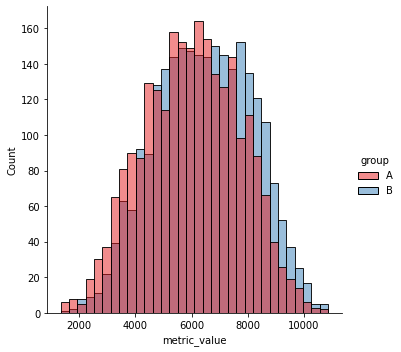

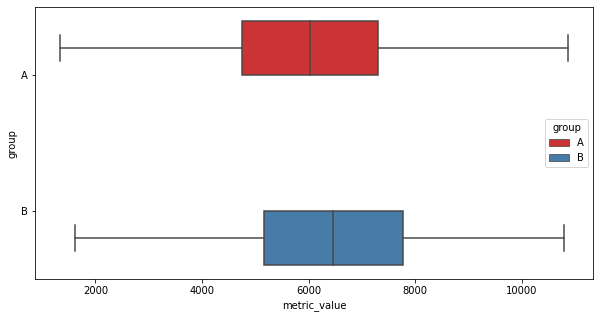

In [ ]:
sns.displot(df_byuser, x="metric_value", hue="group", palette='Set1')
plt.figure(figsize=(10,5))
sns.boxplot(y="group", x="metric_value", hue="group", data = df_byuser , orient="h", palette = 'Set1')

## Проведем исследование количества успешных целевых сессий.

Исследуем равнозначность дисперсий с помощью критерия Левена.

In [ ]:
alpha = 0.05

def levene_test(df1, df2, p_value = alpha):
  st = levene(df1, df2)
  print('Variances of distributions is {}equal\n'.format( {True:'not ', False:''}[st[1] < p_value]))

series_1 = df_byuser.loc[df_byuser.group == 'A']['visits']
series_2 = df_byuser.loc[df_byuser.group == 'B']['visits']

levene_test(series_1, series_2)

Variances of distributions is equal



Проверям на нормальность с помощью критерия Колмогорова-Смирнова.

In [ ]:
st = kstest(pd.Series(series_1), 'norm')
print('Distributions A is {}normal\n'.format( {True:'not ', False:''}[st[1] < alpha]))
st = kstest(pd.Series(series_2), 'norm')
print('Distributions B is {}normal\n'.format( {True:'not ', False:''}[st[1] < alpha]))

Distributions A is not normal

Distributions B is not normal



В предыдущих случае для оценки статистической значимости различий был использован критерий Манна-Уитни. У него есть ограничение: в выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10). В исследуемая выборке некоторое количество повторяющихся данных. Поэтому воспользуемся критерием Краскела-Уоллиса. Это непараметрический ранговый критерий для проверки независимых выборок.

In [ ]:
st = kruskal(pd.Series(series_1), pd.Series(series_2))
print('Diffs is {}significant\n'.format( {True:'not ', False:''}[st[1] < alpha]))

Diffs is significant



Различия между группами статистически значимы. Посмотрим, как именно:

In [ ]:
series_1.describe()

count    2451.000000
mean        4.839657
std         8.789929
min         0.000000
25%         0.000000
50%         0.000000
75%         6.000000
max        66.000000
Name: visits, dtype: float64

In [ ]:
series_2.describe()

count    2549.000000
mean        4.553943
std         8.147190
min         0.000000
25%         0.000000
50%         0.000000
75%         6.000000
max        70.000000
Name: visits, dtype: float64

Среднее количество успешных целевых сессий сократилось для экспериментальной группы.

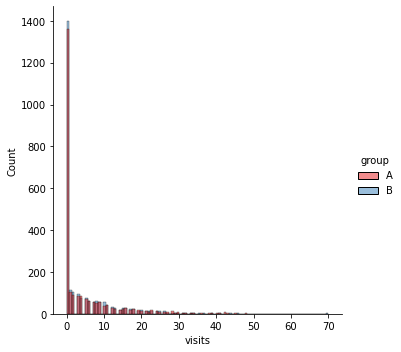

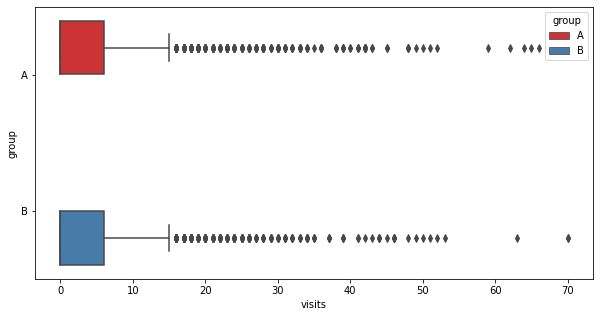

In [ ]:
sns.displot(df_byuser, x="visits", hue="group", palette='Set1')
plt.figure(figsize=(10,5))
sns.boxplot(y="group", x="visits", hue="group", data = df_byuser , orient="h", palette = 'Set1')

## Проведем исследование количества сессий, не закончившихся успешным целевым действием.

Исследуем равнозначность дисперсий с помощью критерия Левена.

In [ ]:
alpha = 0.05

def levene_test(df1, df2, p_value = alpha):
  st = levene(df1, df2)
  print('Variances of distributions is {}equal\n'.format( {True:'not ', False:''}[st[1] < p_value]))

series_1 = df_byuser.loc[df_byuser.group == 'A']['churn_visits']
series_2 = df_byuser.loc[df_byuser.group == 'B']['churn_visits']

levene_test(series_1, series_2)

Variances of distributions is equal



Проверям на нормальность с помощью критерия Колмогорова-Смирнова.

In [ ]:
st = kstest(pd.Series(series_1), 'norm')
print('Distributions A is {}normal\n'.format( {True:'not ', False:''}[st[1] < alpha]))
st = kstest(pd.Series(series_2), 'norm')
print('Distributions B is {}normal\n'.format( {True:'not ', False:''}[st[1] < alpha]))

Distributions A is not normal

Distributions B is not normal



Оцениваем статистическую значимость различий с помощью метода Краскела-Уоллиса. 

In [ ]:
st = kruskal(pd.Series(series_1), pd.Series(series_2))
print('Diffs is {}significant\n'.format( {True:'not ', False:''}[st[1] < alpha]))

Diffs is significant



Различия между группами статистически значимы, посмотрим, как именно:

In [ ]:
series_1.describe()

count    2451.000000
mean        6.929417
std         1.944200
min         0.000000
25%         6.000000
50%         7.000000
75%         9.000000
max         9.000000
Name: churn_visits, dtype: float64

In [ ]:
series_2.describe()

count    2549.000000
mean        6.980384
std         1.930404
min         0.000000
25%         6.000000
50%         7.000000
75%         9.000000
max         9.000000
Name: churn_visits, dtype: float64

Среднее количество сессий, не завершившихся целевым действием увеличилось для экспериментальной группы.

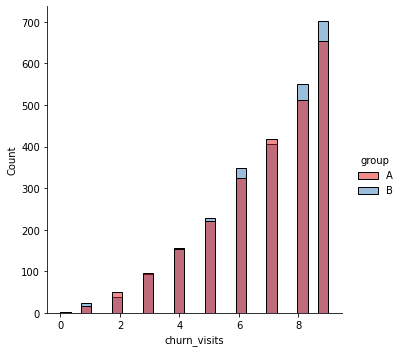

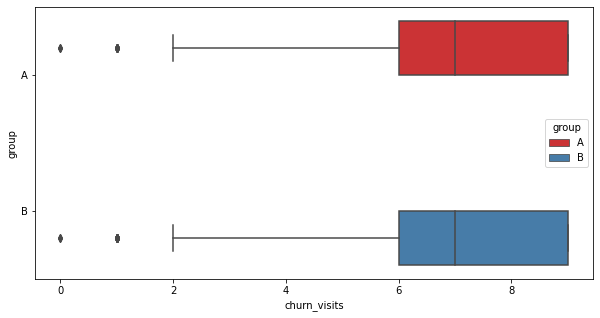

In [ ]:
sns.displot(df_byuser, x="churn_visits", hue="group", palette='Set1')
plt.figure(figsize=(10,5))
sns.boxplot(y="group", x="churn_visits", hue="group", data = df_byuser , orient="h", palette = 'Set1')

## Исследование для количества пользователей, не совершивших целевое действие.

In [ ]:
df_bybucket['group'] = df_bybucket.apply(lambda x: 'A' if x.group_id <= 8 else 'B', axis=1)
df_bybucket.head()

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,1,1875345.0,155,1419,151,2207,A
1,2,1662237.0,138,1320,127,1853,A
2,3,1784372.0,128,1281,159,2032,A
3,4,1876826.0,163,1644,168,2172,A
4,5,1913180.0,156,1675,174,2273,A


In [ ]:
series_1 = df_bybucket.loc[df_bybucket.group == 'A']['churn_users']
series_2 = df_bybucket.loc[df_bybucket.group == 'B']['churn_users']

Исслеудем на нормальность с помощью критерия Шапиро: 

In [ ]:
alpha = 0.05

st = shapiro(pd.Series(series_1))
print('Distribution A is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))
st = shapiro(pd.Series(series_2))
print('Distribution B is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Distribution A is normal

Distribution B is normal



Распределения имеют нормальный вид. Для проверки равенства дисперсий восолпьзуемся F-критерием Фишера: параметрический, основан на предположении о равенстве выборок нормальному закону.

In [ ]:
alpha = 0.05
p_value = f_oneway(series_1, series_2)[1]
print('{} the H0: Var(X1) == Var(X2)\n'.format({True:'Reject', False:'Confirm'}[p_value > alpha]))

Confirm the H0: Var(X1) == Var(X2)



Выборки имеют вид нормального распределения и равенство дисперсий. Для оценки статистической значимости различий воспользуемся t-критерием Стьюдента.

In [ ]:
alpha = 0.05

st = ttest_ind(series_1, series_2)
print('Diffs is {}significant\n'.format({True:'not ',False:''}[st[1] < alpha]))

Diffs is not significant



Разница статистически не значима. Достоверны ли выводы для данного объема выборки?

In [ ]:
effect = 0.8
alpha = 0.05
power = 0.8

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 25.525


Имеющиеся выборка размером 16. Нам нужна выборка большего размера - хотя бы 25 значений.

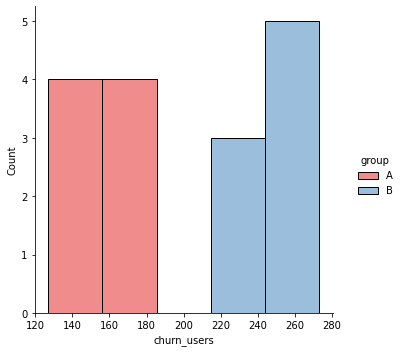

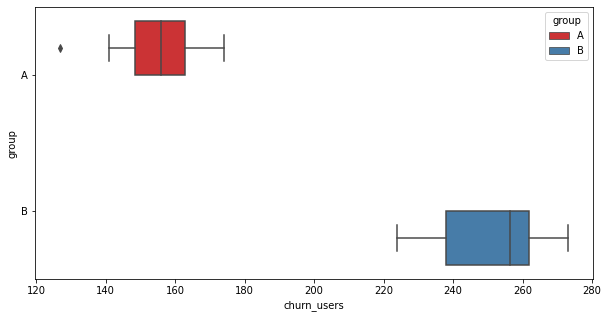

In [ ]:
sns.displot(df_bybucket, x="churn_users", hue="group", palette='Set1')
plt.figure(figsize=(10,5))
sns.boxplot(y="group", x="churn_users", hue="group", data = df_bybucket , orient="h", palette = 'Set1')